# DSP: Filters

*This material is a joint work of TAs and the instructor from IC Lab at KAIST, including Woohyeok Choi, Sangjun Park, Yunjo Han, Soowon Kang, Auk Kim, Inyeob Kim, Minhyung Kim, Hansoo Lee, Uichin Lee, Cheul Y. Park, and Eunji Park. This work is licensed under CC BY-SA 4.0.*

## Preparation

In [1]:
!pip install plotly numpy pandas scipy

In [2]:
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

colors = px.colors.qualitative.Plotly

## Spectral Leakage

When using the Discrete Fourier Transform (DFT) to compute frequency spectra, it's essential to adjust the window size accordingly. However, the process of windowing can inadvertently introduce what's known as "spectral leakage." In essence, the DFT assumes periodicity within a given window, but windowing can cause abrupt transitions at the window boundaries, creating a gap between the start and end of the window. This phenomenon leads to the spreading of energy across frequency components, thereby resulting in spectral leakage.

To illustrate spectral leakage, consider the code snippet below.

The original signal is represented as a cosine wave with a frequency of 2Hz, and the DFT is evaluated for two distinct window sizes. As depicted in the first row of the output, when the window size perfectly accommodates the frequency, no spectral leakage is evident. However, in cases where there's a sharp transition at the window boundaries, neighboring frequency bins also exhibit non-zero magnitudes, as shown in the second row.

In [3]:
duration = 2 # in seconds

#To mimic continuous signal, set frequency large
f_c = 2000
t = np.arange(f_c*duration)/f_c

f_0 = 2
signal = np.cos(2*np.pi * f_0 * t)

f_s = 20 # sampling frequency
fig = make_subplots(rows=2, cols=2)
for idx, window_size in enumerate([2, 1.8]):
    num_samples = int(window_size*f_c)
    sampled_t = t[:num_samples][::f_c//f_s]
    sampled_signal = signal[:num_samples][::f_c//f_s]

    fig.append_trace(
        go.Scatter(x =t, y= signal, mode="lines", showlegend = (idx == 0), name ="original", marker_color = colors[0]),
        row = idx+1, col = 1)
    fig.append_trace(
        go.Scatter(x =sampled_t, y=sampled_signal, mode="markers", showlegend = (idx == 0), name= "sampled", marker_color = colors[1]),
        row = idx+1, col = 1)

    Xk = np.fft.fftshift(np.fft.fft(sampled_signal))
    freq = np.fft.fftshift(np.fft.fftfreq(len(sampled_signal),1/f_s))

    magnitude = np.absolute(Xk)
    fig.append_trace(
        go.Scatter(x = freq, y = magnitude, mode = "markers", showlegend = False, marker_color = colors[2]),
        row = idx+1, col = 2
    )
    fig.append_trace(
        go.Bar(x = freq, y = magnitude, width = 1/f_s, showlegend = (idx == 0), name= "magnitude", marker_color = colors[2]),
        row = idx+1, col = 2
    )

fig.update_layout(
    yaxis = dict(title="Window Size: 2s"),
    yaxis3 = dict(title="Window Size: 1.8s"),
    xaxis3 = dict(title = "time (s)"),
    xaxis4 = dict(title = "freq (Hz)")
)
fig.show()

### Hamming Window


To solve the problem of spectral leakage caused by abrupt changes between the start and end of a window, it's common to use window functions like the Hamming window.
The Hamming window can be applied by multiplying the Hamming function into the signal (e.g., `cos(t) * np.hamming(N)`). This process concentrates the signal's magnitude within frequency bins centered around 2Hz, as demonstrated in the third row.

*Please think about why hamming window can reduce the spectral leakage along with its shape*

In [4]:
# Illustrate shape of hamming window
fig = go.Figure()
fig.add_trace(go.Bar(x = np.arange(20), y= np.hamming(20), width = .1, showlegend = False, marker_color = colors[2]))
fig.add_trace(go.Scatter(x = np.arange(20), y= np.hamming(20), mode = "markers", showlegend = False, marker_color = colors[2] ))
fig.update_layout(
    width = 500,
    height = 500
)
fig.show()

In [5]:
signals = []

# First row, window size 2s
window_size = 2
num_samples = int(window_size*f_c)
sampled_t = t[:num_samples][::f_c//f_s]
sampled_signal = signal[:num_samples][::f_c//f_s]
signals.append([sampled_t, sampled_signal])

# Second row, window size 1.8s
window_size = 1.8
num_samples = int(window_size*f_c)
sampled_t = t[:num_samples][::f_c//f_s]
sampled_signal = signal[:num_samples][::f_c//f_s]
signals.append([sampled_t, sampled_signal])

# Third row, window size 1.8s with hamming window
sampled_signal =  np.hamming(len(sampled_t)) * sampled_signal
signals.append([sampled_t, sampled_signal])


fig = make_subplots(rows= 3, cols=2)
for idx, (t_, signal_) in enumerate(signals):
    fig.append_trace(
        go.Scatter(x =t, y= signal, mode="lines", name ="original", showlegend = (idx == 0), marker_color = colors[0]),
        row = idx+1, col = 1)
    fig.append_trace(
        go.Scatter(x =t_, y=signal_, mode="markers", showlegend = (idx == 0), name= "sampled", marker_color = colors[1]),
        row = idx+1, col = 1)

    Xk = np.fft.fftshift(np.fft.fft(signal_))
    freq = np.fft.fftshift(np.fft.fftfreq(len(t_),1/f_s))
    magnitude = np.absolute(Xk)

    fig.append_trace(
        go.Scatter(x = freq, y = magnitude, mode = "markers", showlegend = False, marker_color = colors[2]),
        row = idx+1, col = 2
    )
    fig.append_trace(
        go.Bar(x = freq, y = magnitude, width = 1/f_s, showlegend = (idx == 0), name= "magnitude", marker_color = colors[2]),
        row = idx+1, col = 2
    )

fig.update_layout(
    yaxis = dict(title="2s"),
    yaxis3 = dict(title="1.8s"),
    yaxis5 = dict(title="w/ Hamming"),
    xaxis5 = dict(title = "time(s)"),
    xaxis6 = dict(title = "freq(hz)")
)
fig.show()

### Various Windowing Function
Other than the Hamming window, there are various other windowing functions commonly used in signal processing as shown in the code below:

In [6]:
num_samples = 100
n = np.arange(num_samples)

fig = go.Figure()
fig.add_trace(go.Scatter(x=n, y=np.hamming(num_samples), name='hamming'))
fig.add_trace(go.Scatter(x=n, y=np.bartlett(num_samples), name='bartlett'))
fig.add_trace(go.Scatter(x=n, y=np.blackman(num_samples), name='blackman'))
fig.add_trace(go.Scatter(x=n, y=np.hanning(num_samples), name='hanning'))
fig.add_trace(go.Scatter(x=n, y=np.kaiser(num_samples,10), name='kaiser'))
fig.update_layout(width=1000, height=500)
fig.show()

## Low Pass Filter (LPF)

A filter is a function that takes an original signal ($x(n)$) and produces a transformed signal ($y(n)$). This transformation can be represented by a linear equation of $x(n)$ and $y(n)$ as shown below:

$$b_0y(n) + b_1y(n-1) + b_1y(n-2) + \dots + b_qy(n-q) = a_0x(n)+a_1x(n-1) + a_2x(n-2) + \dots + a_p x(n-p)$$

We can simplify the above equation by defining $h(n)$ and employing convolution.
    
$$y(n) = x(n) * h(n) = \sum_{k=-\infty}^{\infty} x(k)h(n-k)$$
$$b_0h(n) + b_1h(n-1) + \dots + b_qh(n-q) = a_0 \mathbb{1}(n = 0) + a_1 \mathbb{1}(n=1)+ a_2 \mathbb{1}(n=2) + \dots + + a_p \mathbb{1}(n=p)$$


Using Fourier Transform, we can convert the signal and filter into the frequency domain, which simplifies convolution in the time domain to multiplication in the frequency domain.

$$Y(f) = H(f)X(f)$$
$$H(2\pi f) = \frac{a_0 + a_1e^{-2\pi jf} +a_2e^{-4\pi jf}+ \dots a_p e^{-2p \pi jf}}{b_0 + b_1e^{-2\pi jf} +b_2e^{-4\pi jf} + \dots b_q e^{-2\pi qjf}}$$

Additionally, filters can be classified into two types:

* FIR (Finite Impulse Response): Filters that can be constructed using only the input signal $x(n)$.
* IIR (Infinite Impulse Response): Filters that can be constructed using the previous output signal $y(n-1)$.

We will now explore a representative example of FIR and IIR filters.

*Note: Here, we assumed that the filter is causal LTI system. To find out detail, please refer to the book, "Discrete-Time Signal Processing 3rd Ed., A.V. Oppenheim and R.W. Schafer, Prentice-Hall 2009."*

### Ideal Low Pass Filter

The ideal low-pass filter will look like::

$$H(f) =1 \text{ (if }f < f_{\text{c}}\text{) } 0 \text{ (Otherwise)}$$

Calculating the time domain signal will result in a sinc function:

$$h(n) = 2f_{\text{c}} \frac{\sin{2\pi f_{\text{c}} n}}{2\pi f_{\text{c}} n}$$

Let's visualize what the ideal low-pass filter looks like in both the time and frequency domains.

In [7]:
# Visualize Ideal LPF
# f_c states cutoff frequency
f_c = 3

# We randomly set an odd number N and sampling frequency f_s to generate the frequency domain signal H(f).
# As long as N is sufficiently large, its value should not affect the shape of the filter.
N, f_s = 101, 30.
t = np.arange(-f_s*(N//2), f_s*(N//2))/f_s
freq = np.arange(-f_s*(N//2), f_s*(N//2))/N

h_freq = np.ones_like(freq)
h_freq[np.absolute(freq) > f_c] = 0

h_time = np.real(np.fft.ifft(np.fft.ifftshift(h_freq)))

fig = make_subplots(rows=1, cols=2)
# Frequency domain
fig.add_trace(
    go.Scatter(x = freq, y = h_freq, mode="lines", showlegend=False), row = 1, col = 1
)
# Time domain
fig.add_trace(
    go.Scatter(x = np.arange(-f_s*(N//2), f_s*(N//2))/f_s, y = np.fft.fftshift(h_time), mode="lines", showlegend=False), row = 1, col = 2
)
fig.update_layout(
    xaxis = dict(title = "freq (Hz)"),
    xaxis2= dict(title = "time (sec)", range = [-5,5]),
    width = 1000,
    height = 500
)
fig.show()

Let's look at how signal changes after applying the ideal LPF that has  different cutoff frequency.

As the cutoff frequency decreases, the signal becomes smoother, meaning that only low frequency components remain.


In [8]:
np.random.seed(2023)
f_s = 40
hat = np.array([*np.zeros(100), *np.ones(100), *np.zeros(100)])
noisy = hat + np.random.normal(0, .1, 300)
t = np.arange(300)/f_s

def idealLPF(signal, f_s, f_c):
    Xk  = np.fft.fftshift(np.fft.fft(signal))
    freq = np.fft.fftshift(np.fft.fftfreq(len(signal),1/f_s))
    Xk[np.absolute(freq) > f_c] = 0
    return np.real(np.fft.ifft(np.fft.ifftshift(Xk)))

fig = make_subplots(rows=1, cols=4, shared_yaxes= True)
for idx, val in enumerate([np.inf, 11, 5, 1]):
    fig.add_trace(go.Scatter(x = t, y = idealLPF(noisy, f_s = f_s, f_c = val) if idx !=0 else noisy, showlegend = False), row=1 , col=idx+ 1)

fig.update_layout(
    width=1200,
    height=400,
    xaxis = dict(title="Original"),
    xaxis2 = dict(title="f_c: 11"),
    xaxis3 = dict(title="f_c: 5"),
    xaxis4 = dict(title="f_c: 1"),
    yaxis = dict(title = "magnitude")
)
fig.show()

### FIR Filter: Moving Average Filter

In practice, it is not possible to create an ideal low-pass filter. A common real-world example of a low-pass filter is the moving average filter.

Since the moving average filter does not require knowledge of the previous output signal ($y$), it is classified as a finite impulse response (FIR) filter.

Applying the moving average filter will transform the input signal $x(n)$ to the output signal $y(n)$ as shown below:

$$y(n) = \frac{1}{N}\sum_{k=0}^{N-1} x(n-k)$$

where $N$ is the number of taps in the filter (i.e., the size of the moving window).

The moving average filter can be desribed as below in time domain and frequency domain:
$$h(n) = \frac{1}{N}\sum_{k=0}^{N-1} \mathbb{1}(n = k), H(2\pi f)= \frac{1}{N}\frac{1-e^{-2\pi f jN}}{1-e^{-2\pi jf }}$$



As $N$ increases, the width of transition band decreases, the signal becomes  smoother (i.e., high frequency component is removed), and pass band ripple will become smaller.

In [9]:
from scipy import signal

f_s = 40 # cut off frequecy would determine by f_s
fig = make_subplots(rows= 1, cols=3)

for idx, N in enumerate([5, 11, 21]):
    # signal.freqz(a ,b=1, fs)
    # a: filter's numerator as an array
    # fs: sampling frequency
    # it will return freq and frequency response
    freq, h_freq = signal.freqz(np.ones(N)/N , fs = f_s)

    fig.add_trace(
        go.Scatter(x = freq, y = np.abs(h_freq), mode="lines", name = f"N: {N}"), row = 1, col = idx + 1
    )
    fig.update_layout(
        **dict({
            "xaxis" + ("" if idx ==0 else str(idx+1)): dict(title = f"freq(hz)")
        })
    )

fig.update_layout(
    width = 1200,
    height = 400,
    yaxis = dict(title = "magnitude")
)
fig.show()

Let's look how the moving average filter transforms the signal.

As $N$ increases, you can notice that signal becomes smoother, but transition is distorted to have some slope.

In [10]:
fig = make_subplots(rows=1, cols=4, shared_yaxes= True)

for idx, N in enumerate([1, 5, 11, 21]):
    # signal.filter(a,b,x):
    # a: filter's numerator as an array
    # b: filter's denominator as an array
    # x: x is signal we want to apply filter
    fig.add_trace(go.Scatter(x =t ,y = signal.lfilter(np.ones(N)/N, [1], noisy), showlegend = False), row=1 , col=idx+ 1)

fig.update_layout(
    width=1200,
    height=400,
    xaxis = dict(title="Original"),
    xaxis2 = dict(title="MA: 5"),
    xaxis3 = dict(title="MA: 11"),
    xaxis4 = dict(title="MA: 21"),
    yaxis = dict(title = "magnitude")

)
fig.show()

### IIR Filter: Butterworth Filter

The representative filter of IIR filter is a butterworth filter.

The butterworth filter can be defined using cut-off frequency($f_c$) and order($N$).
$$|H(f)|^2= 1/\{1+(\frac{f}{f_c})^{2N}\}$$



In [11]:
# butterworth filter is complex to implement from no baseline
# We will use butterworth filter supported by scipy
# returned value b is numerator, and a is denominator.

fig = make_subplots(rows= 1, cols=3)

for idx, N in enumerate([5, 11, 21]):
    # signal.butter(N, Wn, fs)
    # Wn correspond to cut-off
    # butterworth filter can be supported by scipy.signal.butter
    b, a = signal.butter(N, Wn  =15, fs = f_s)
    freq, h_freq = signal.freqz(b, a, fs= f_s)

    fig.add_trace(
        go.Scatter(x = freq, y = np.abs(h_freq), mode="lines", name = f"N: {N}"), row = 1, col = idx + 1
    )
    fig.update_layout(
        **dict({
            "xaxis" + ("" if idx ==0 else str(idx+1)): dict(title = f"freq(hz)")
        })
    )

fig.update_layout(
    width = 1200,
    height = 400,
    yaxis = dict(title = "magnitude")
)
fig.show()

Let's compare different settings of order ($N$) and cut-off frequency ($f_c$).

We can see that increasing $f_c$ allows more noise to pass through, as shown in the first row. With increasing $N$, ripples occurred on the transtion of the signal.

In [12]:
fig = make_subplots(rows=1, cols=4, shared_yaxes= True)
f_s = 40

# Setting different cut-off frequency f_c
for idx, f_c in enumerate([1, 5, 15, 21]):
    b, a = signal.butter(5, f_c/f_s, 'low')
    fig.add_trace(go.Scatter(y = signal.lfilter(b,a, noisy) if idx > 0 else noisy, showlegend = False), row=1 , col=idx+ 1)

fig.update_layout(
    title = "Fixed N: 5, vary f_c",
    width=1200,
    height=400,
    xaxis = dict(title="Original"),
    xaxis2 = dict(title="f_c: 5"),
    xaxis3 = dict(title="f_c: 15"),
    xaxis4 = dict(title="f_c: 21"),
    yaxis = dict(title = "magnitude")

)
fig.show()

fig = make_subplots(rows=1, cols=4, shared_yaxes= True)

# Setting different order N
for idx, N in enumerate([1, 2, 5, 11]):
    b, a = signal.butter(N, 5/f_s, 'low')
    fig.add_trace(go.Scatter(y = signal.lfilter(b,a, noisy) if idx > 0 else noisy, showlegend = False), row=1 , col=idx+ 1)

fig.update_layout(
    title = "Fixed f_c: 5, vary N",
    width=1200,
    height=400,
    xaxis = dict(title="Original"),
    xaxis2 = dict(title="N: 2"),
    xaxis3 = dict(title="N: 5"),
    xaxis4 = dict(title="N: 11"),
    yaxis = dict(title = "magnitude")

)
fig.show()

## Correlation

Cross-correlation and autocorrelation are two statistical methods used to analyze the relationships between signals or time series data. They are often employed in fields like signal processing, data analysis, and engineering to understand the relationships between variables and to find repeating patterns or trends in the data.

### Cross-correlation

Cross-correlation is a way to find the extent to which one signal or time series can predict another by comparing them at various time lags. It is useful in determining the similarities or common patterns between two signals, and it is often used to identify the time delay between related events in the two signals.

Using ```numpy.correlate```, we can compute cross-correlation of two 1-dimensional sequences.

In [13]:
x = np.array([3, 1, 4])
y = np.array([2, 7, 1])

np.correlate(x, y)
print("Correlation", np.correlate(x, y))
# In default mode, the output consists only of the points where the signals fully overlap.
# The result is an array of size max(M, N) - min(M, N) + 1, where M and N are the lengths of the input arrays.

np.correlate(x, y, "same")
print("Cross-correlation (same): ", np.correlate(x, y, "same"))
# In 'same' mode, the output has the same size as the largest input array.
# The signals are aligned so that the central point of the smaller array is aligned with the central point of the larger array, resulting in an output array of size max(M, N).

np.correlate(x, y, "full")
print("Cross-correlation (full): ", np.correlate(x, y, "full"))
# In 'full' mode, the output array contains the cross-correlation computed at all possible positions, including positions with minimal or no overlap between the input arrays.
# The output array size will be M + N - 1 elements, where M and N are the sizes of the input arrays.

Correlation [17]
Cross-correlation (same):  [22 17 30]
Cross-correlation (full):  [ 3 22 17 30  8]


### Autocorrelation

Autocorrelation is a statistical method used to analyze the relationship between a signal or time series and a time-shifted (lagged) version of itself. The purpose of autocorrelation is to determine how the values of a time series are related to their past values over different time lags. It can reveal trends, seasonality, or cyclical patterns in the data. High autocorrelation indicates that the data points are dependent on their past values, while low autocorrelation suggests that the data points are more independent of their past values.

Using ```numpy.correlate```, we can compute auto-correlation of a 1-dimensional sequence for all possible lags.



In [14]:
def autocorr(x):
  rst = np.correlate(x, x, mode='full')
  return rst[rst.size//2:]

x = np.array([3, 1, 4])

print("Autocorrelation:", autocorr(x))

Autocorrelation: [26  7 12]


# Homework #4
Homework #4 is due on **3/31 at 23:59**. Submit your Colab file via KLMS.

At first,
1. Clone a GitHub repository.
2. Load CSV files containing PPG data.
3. Then, we show you a example how to visualize the filtered signal against the raw signal.
4. Pre-knowledge you need to learn for the homework.

In [15]:
!git clone https://github.com/DejiangZ/IoTLab04.git


Cloning into 'IoTLab04'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 204.45 KiB | 2.15 MiB/s, done.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
# Ensures inline plots in Colab
%matplotlib inline

In [17]:
# Path to the CSV file
ppg_file = "/content/IoTLab04/P02/baseline/galaxy_ppg.csv"

# Read into a pandas DataFrame
df_ppg = pd.read_csv(ppg_file)

# Inspect the first few rows
df_ppg.head()


,time,ppg
0,1710812342044,2011629
1,1710812342083,2006563
2,1710812342124,2003854
3,1710812342164,2002360
4,1710812342204,2001978


**Prerequisites**

> Understanding Peak Detection

Peak detection is a crucial technique in biosignal processing, particularly for analyzing PPG (Photoplethysmogram) and ECG (Electrocardiogram) signals.

> Why Peak Detection?

1.  Calculate heart rate by measuring the time between consecutive peaks
2.  Analyze heart rate variability (HRV) by studying peak-to-peak intervals
3.  Detect irregular heartbeat patterns or anomalies

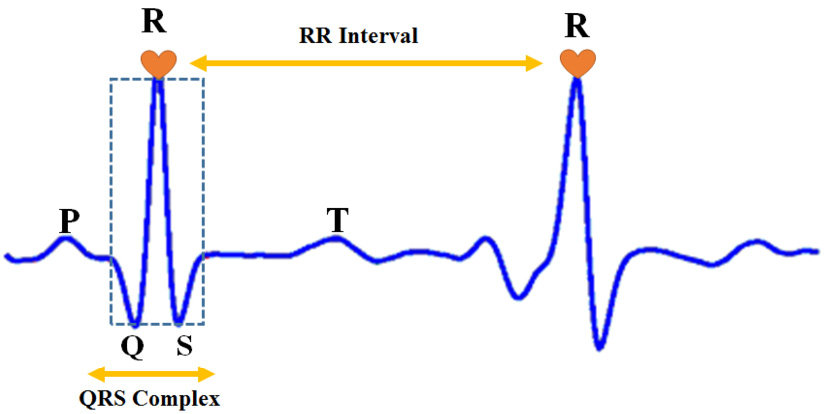
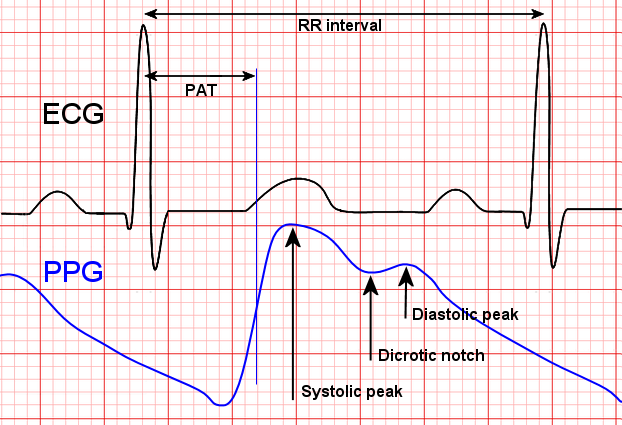






* Here, we show you a classic and popular open-source peak detection algorithm, it is a good start for you to perform the this homework.

In [18]:
!pip install heartpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.1 MB/s eta 0:00:00



=== Starting HeartPy Tutorial ===

Step 1: Loading our heart signal data...
--------------------------------
✓ Data loaded successfully!
We have 2483 data points to analyze

Step 2: Understanding our signal...
--------------------------------
For accurate analysis, we need to know our sampling rate.
In this example, we're using 100 Hz (100 samples per second)

Step 3: Looking for heartbeats...
--------------------------------
Now we'll use HeartPy to find the heartbeats in our signal
✓ Processing completed successfully!

Step 4: Understanding our results...
--------------------------------
Average Heart Rate: 58.9 beats per minute
RMSSD (heart rate variability): 64.6 ms
Number of detected beats: 24

Step 5: Creating visualizations...
--------------------------------
I'm now going to show you two important plots:
1. The signal with detected peaks
2. A Poincare plot (shows heart rate variability pattern)

=== Tutorial Tips ===
1. For noisy signals, try filtering first:
   filtered = hp.

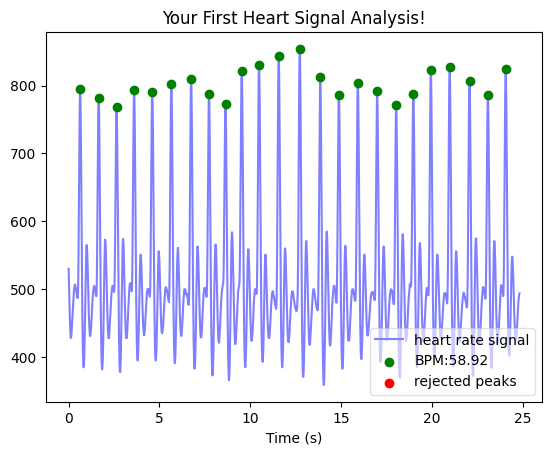

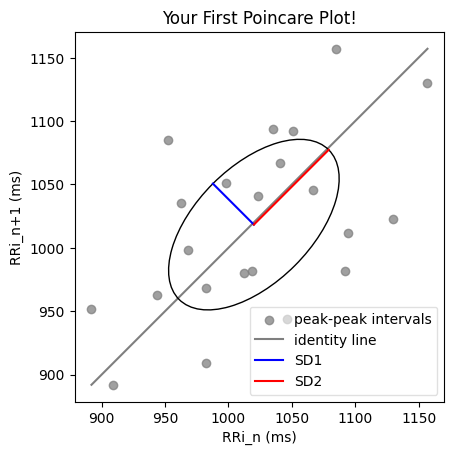

In [19]:
import heartpy as hp

def teach_heartpy():
    # Step 1: Let's load some example data
    print("Step 1: Loading our heart signal data...")
    print("--------------------------------")
    data, timer = hp.load_exampledata(0)  # Example 0 is a nice clean signal
    print("✓ Data loaded successfully!")
    print(f"We have {len(data)} data points to analyze\n")

    # Step 2: Let's look at our signal's properties
    print("Step 2: Understanding our signal...")
    print("--------------------------------")
    print("For accurate analysis, we need to know our sampling rate.")
    print("In this example, we're using 100 Hz (100 samples per second)")
    sample_rate = 100.0

    # Step 3: Process the signal
    print("\nStep 3: Looking for heartbeats...")
    print("--------------------------------")
    print("Now we'll use HeartPy to find the heartbeats in our signal")

    try:
        working_data, measures = hp.process(
            data,
            sample_rate=sample_rate,
            high_precision=True,    # For more accurate peak detection
            clean_rr=True,          # To clean up our intervals
            reject_segmentwise=True # To reject noisy segments
        )
        print("✓ Processing completed successfully!\n")

        # Step 4: Let's look at what we found
        print("Step 4: Understanding our results...")
        print("--------------------------------")
        print(f"Average Heart Rate: {measures['bpm']:.1f} beats per minute")
        print(f"RMSSD (heart rate variability): {measures['rmssd']:.1f} ms")
        print(f"Number of detected beats: {len(working_data['peaklist'])}")

        # Step 5: Visualization
        print("\nStep 5: Creating visualizations...")
        print("--------------------------------")
        print("I'm now going to show you two important plots:")
        print("1. The signal with detected peaks")
        print("2. A Poincare plot (shows heart rate variability pattern)")

        # Plot 1: Signal with peaks
        hp.plotter(working_data, measures, show=True,
                  title="Your First Heart Signal Analysis!")

        # Plot 2: Poincare plot
        hp.plot_poincare(working_data, measures, show=True,
                        title="Your First Poincare Plot!")

    except Exception as e:
        print(f"Oops! Something went wrong: {str(e)}")
        print("Don't worry - this happens! Let's try to understand why:")
        print("1. Check if your signal is too noisy")
        print("2. Make sure your sampling rate is correct")
        print("3. Try filtering your signal first")

def main():
    """
    Main function to run our tutorial
    """
    print("\n=== Starting HeartPy Tutorial ===\n")
    teach_heartpy()

    print("\n=== Tutorial Tips ===")
    print("1. For noisy signals, try filtering first:")
    print("   filtered = hp.filter_signal(data, cutoff=2.5, sample_rate=100.0)")

    print("\n2. If your peaks are upside down:")
    print("   data = hp.flip_signal(data)")

    print("\n3. For ECG signals specifically:")
    print("   data = hp.enhance_ecg_peaks(data, sample_rate)")

if __name__ == "__main__":
    main()

**Utility Functions**


*   These functions may useful for you to finish the homework.
*   You can also design your own function.



In [20]:
def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    """
    Apply bandpass filter to the signal.

    Args:
        signal: Input signal array
        fs: Sampling frequency (Hz)
        lowcut: Lower cutoff frequency (Hz)
        highcut: Higher cutoff frequency (Hz)
        order: Filter order

    Returns:
        Filtered signal
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')

    padlen_required = 3 * (max(len(a), len(b)) - 1)
    if len(signal) <= padlen_required:
        raise ValueError(
            f"Input vector length ({len(signal)}) is too short for the required padlen ({padlen_required}). "
            "Please ensure your window contains enough samples or reduce the filter order."
        )

    return filtfilt(b, a, signal)

def standardize(signal):
    """Standardize signal using z-score normalization"""
    return (signal - np.mean(signal)) / np.std(signal)

def plot_signal(time, signal, title, ylabel='Amplitude'):
    """Utility function to plot signals"""
    plt.figure(figsize=(12, 4))
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Example implementation for students:
def load_data(file_path):
    """
    Load data from CSV file and convert time to seconds

    Args:
        file_path: Path to the CSV file

    Returns:
        DataFrame wion 17 people th 'time_s' column added
    """
    df = pd.read_csv(file_path)
    df['time_s'] = df['time'] / 1000.0
    return df

# Data paths
BASE_PATH = "/content/IoTLab04/P02/"
BASELINE_ECG = f"{BASE_PATH}baseline/polar_ecg.csv"
WALKING_ECG = f"{BASE_PATH}walking/polar_ecg.csv"
BASELINE_PPG = f"{BASE_PATH}baseline/galaxy_ppg.csv"
WALKING_PPG = f"{BASE_PATH}walking/galaxy_ppg.csv"

* Below code block shows how you can load GalaxyPPG data. If you want to explore more about this dataset, you can refer https://zenodo.org/records/14635823.

ECG sampling rate: 130.2 Hz
PPG sampling rate: 25.0 Hz
Number of ECG samples in window: 1042
Number of PPG samples in window: 200


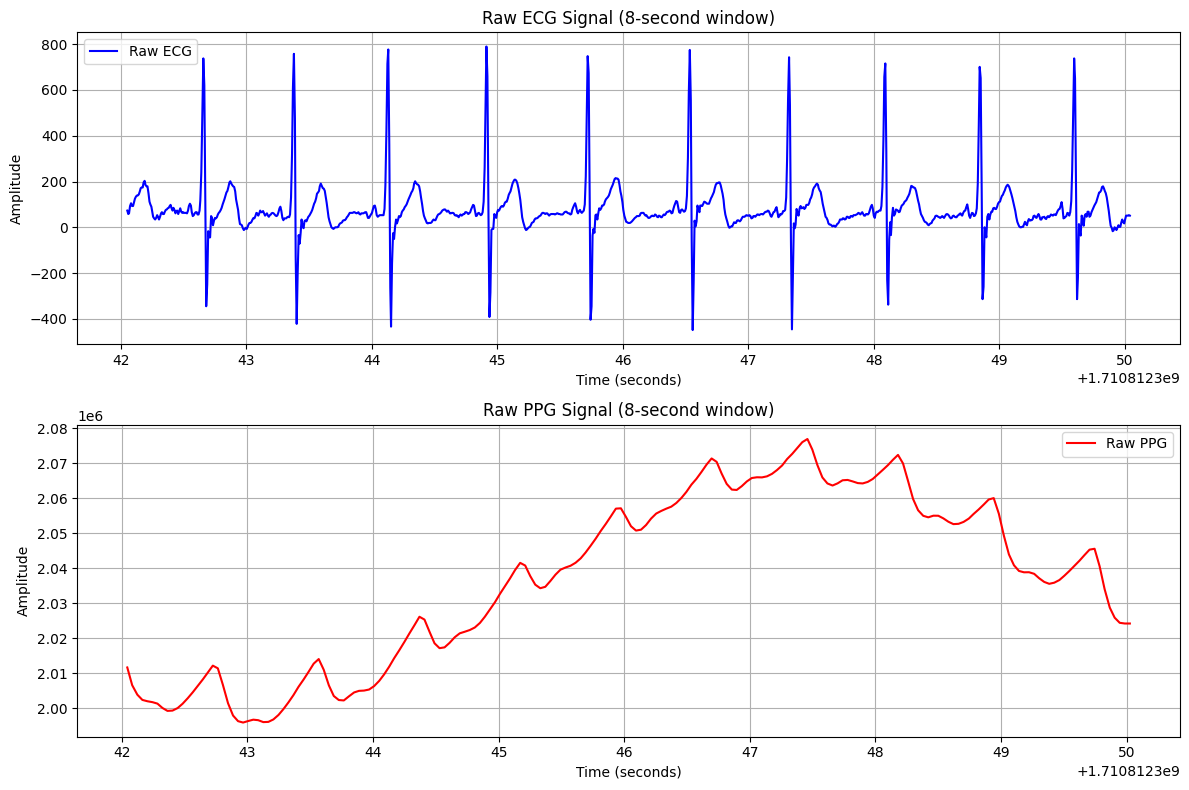

In [21]:
# Load ECG and PPG data for baseline condition
df_ecg_baseline = load_data(BASELINE_ECG)
df_ppg_baseline = load_data(BASELINE_PPG)

# Define window parameters
WINDOW_LENGTH = 8  # seconds
start_time = max(df_ecg_baseline['time_s'].iloc[0], df_ppg_baseline['time_s'].iloc[0])
end_time = start_time + WINDOW_LENGTH

# Extract 8-second windows for both signals
df_ecg_window = df_ecg_baseline[
    (df_ecg_baseline['time_s'] >= start_time) &
    (df_ecg_baseline['time_s'] < end_time)
].copy()

df_ppg_window = df_ppg_baseline[
    (df_ppg_baseline['time_s'] >= start_time) &
    (df_ppg_baseline['time_s'] < end_time)
].copy()

# Calculate sampling rates
ecg_fs = len(df_ecg_window) / WINDOW_LENGTH
ppg_fs = len(df_ppg_window) / WINDOW_LENGTH

print(f"ECG sampling rate: {ecg_fs:.1f} Hz")
print(f"PPG sampling rate: {ppg_fs:.1f} Hz")
print(f"Number of ECG samples in window: {len(df_ecg_window)}")
print(f"Number of PPG samples in window: {len(df_ppg_window)}")

# Plot raw signals
plt.figure(figsize=(12, 8))

# Plot ECG
plt.subplot(2, 1, 1)
plt.plot(df_ecg_window['time_s'], df_ecg_window['ecg'], 'b-', label='Raw ECG')
plt.title('Raw ECG Signal (8-second window)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot PPG
plt.subplot(2, 1, 2)
plt.plot(df_ppg_window['time_s'], df_ppg_window['ppg'], 'r-', label='Raw PPG')
plt.title('Raw PPG Signal (8-second window)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Homework

**Note:**
1. **The previous method is for reference only. You are free to complete the task in any way that makes sense to you—there is no absolute right or wrong**.
2. **The purpose of this assignment is to help you understand the process, not to achieve perfect accuracy**.
3. Completing the process itself is what matters.


## Problem 1: ECG Signal Filtering (1.0 point)
Implement bandpass filtering on ECG signals using different frequency ranges.

**Requirements:**
1. Load the baseline ECG data (0.2 points)

> You can choose any 8 seconds segments of ECG and PPG signal.

2. Apply bandpass filters with ranges:(0.4 points)
   - 5-15 Hz
   - 5-20 Hz
   - 5-25 Hz
   - 5-30 Hz
   - 5-35 Hz
3. Visualize the filtered signals(0.4 points)

Sampling rate 130.375


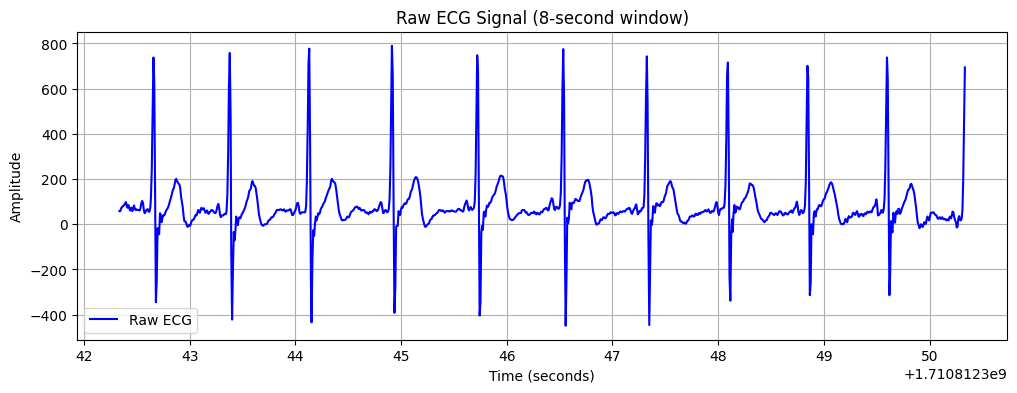

In [22]:
# Load baseline ECG data
ecg_data = load_data(BASELINE_ECG)

WINDOW_LENGTH = 8
random_number = 42
start_time = df_ecg_baseline['time_s'].iloc[random_number]
end_time = start_time + WINDOW_LENGTH

df_ecg_window = ecg_data[
    (ecg_data['time_s'] >= start_time) &
    (ecg_data['time_s'] < end_time)
].copy()
ecg_fs = len(df_ecg_window) / WINDOW_LENGTH
print("Sampling rate", ecg_fs)

plt.figure(figsize=(12, 4))

plt.plot(df_ecg_window['time_s'], df_ecg_window['ecg'], 'b-', label='Raw ECG')
plt.title('Raw ECG Signal (8-second window)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()



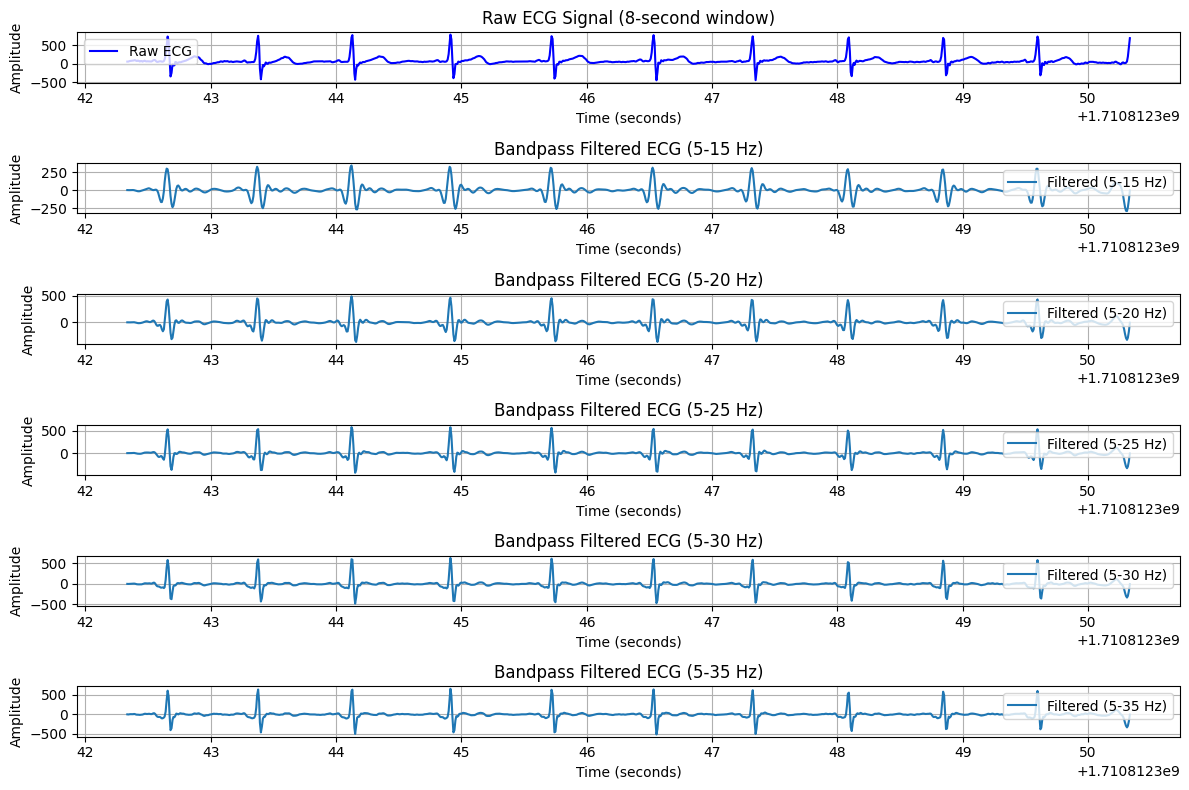

In [23]:
# TODO: Define frequency ranges for filtering
freq_ranges = [
    (5, 15),
    (5, 20),
    (5, 25),
    (5, 30),
    (5, 35)
]
# Your code here
# Apply filters and visualize results
plt.figure(figsize=(12, 8))

# Plot raw signal for comparison
plt.subplot(len(freq_ranges) + 1, 1, 1)
plt.plot(df_ecg_window['time_s'], df_ecg_window['ecg'], 'b-', label='Raw ECG')
plt.title('Raw ECG Signal (8-second window)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Apply bandpass filters and plot filtered signals
for i, (lowcut, highcut) in enumerate(freq_ranges):
    filtered_ecg = bandpass_filter(df_ecg_window['ecg'], ecg_fs, lowcut, highcut)

    plt.subplot(len(freq_ranges) + 1, 1, i + 2)
    plt.plot(df_ecg_window['time_s'], filtered_ecg, label=f'Filtered ({lowcut}-{highcut} Hz)')
    plt.title(f'Bandpass Filtered ECG ({lowcut}-{highcut} Hz)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Problem 2: ECG Peak Detection (1.0 point)
Implement R-peak detection for ECG signals under baseline and walking conditions.

### 2.1 Baseline & Walking Condition (0.5 point)
Detect R-peaks in the baseline and walking condition of ECG signal using heartpy.

In [24]:
# My code here:
# load baseline ECG data
baseline_ecg_data, walking_ecg_data= None, None
ecg_datas = {}
for file_path in [BASELINE_ECG, WALKING_ECG]:
  ecg_data = load_data(file_path)

  WINDOW_LENGTH = 8
  random_number = 42

  start_time = ecg_data['time_s'].iloc[random_number]
  end_time = start_time + WINDOW_LENGTH

  df_ecg_window = ecg_data[
      (ecg_data['time_s'] >= start_time) &
      (ecg_data['time_s'] < end_time)
  ].copy()

  ecg_fs = len(df_ecg_window) / WINDOW_LENGTH

  if file_path == BASELINE_ECG:
    print("Baseline ECG")
  else:
    print("Walking ECG")
  ecg_datas[file_path] = df_ecg_window['ecg'].values

  print("Sampling rate", ecg_fs)
  # filter
  lowcut = 5
  highcut = 35
  ecg_datas[file_path] = bandpass_filter(ecg_datas[file_path], ecg_fs, lowcut, highcut)


Baseline ECG
Sampling rate 130.375
Walking ECG
Sampling rate 130.375


Baseline ECG
--------------------------------
Average Heart Rate: 77.9 beats per minute
RMSSD (heart rate variability): 22.2 ms
Number of detected beats: 10


Walking ECG
--------------------------------
Average Heart Rate: 86.7 beats per minute
RMSSD (heart rate variability): 16.9 ms
Number of detected beats: 11




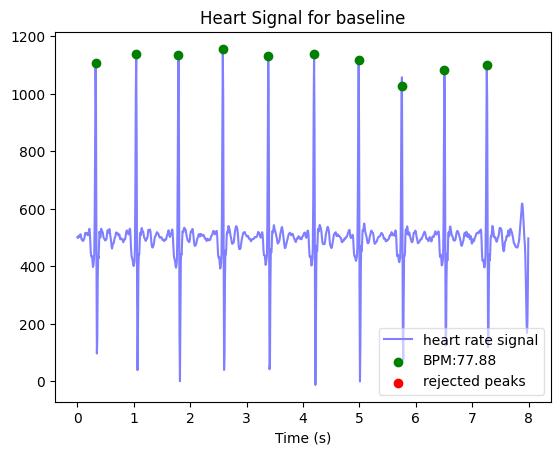

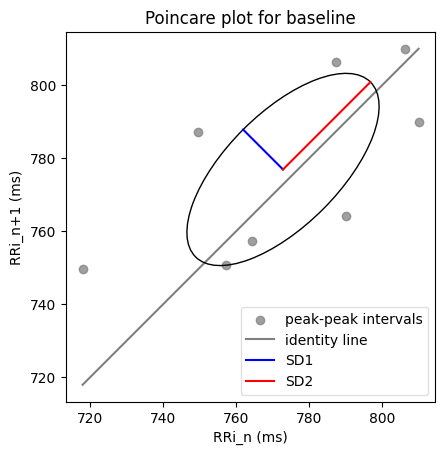

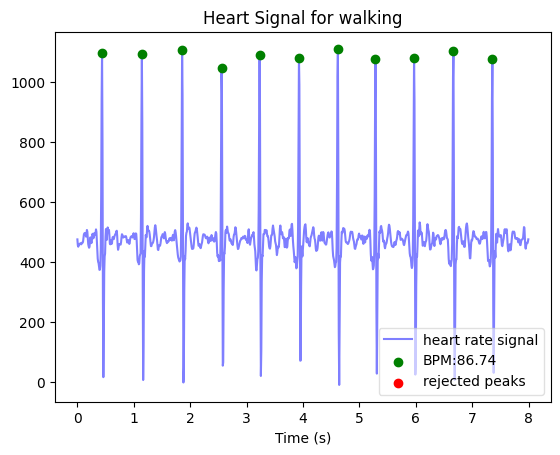

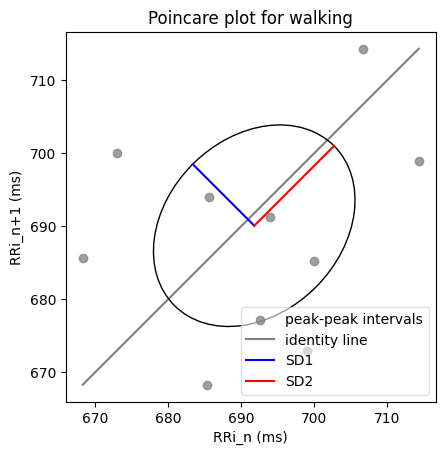

In [25]:

for k, ecg_data in ecg_datas.items():
  working_data, measures = hp.process(
      ecg_data,
      sample_rate=ecg_fs,
      high_precision=True,
      clean_rr=True,
      reject_segmentwise=True
      )

  if k == BASELINE_ECG:
    print("Baseline ECG")
    heart_title = "Heart Signal for baseline"
    poincare_title = "Poincare plot for baseline"
  else:
    print("Walking ECG")
    heart_title = "Heart Signal for walking"
    poincare_title = "Poincare plot for walking"

  print("--------------------------------")
  print(f"Average Heart Rate: {measures['bpm']:.1f} beats per minute")
  print(f"RMSSD (heart rate variability): {measures['rmssd']:.1f} ms")
  print(f"Number of detected beats: {len(working_data['peaklist'])}")
  print("\n")

  # Plot 1: Signal with peaks
  hp.plotter(working_data, measures, show=True,
            title=heart_title)

  # Plot 2: Poincare plot
  hp.plot_poincare(working_data, measures, show=True, title=poincare_title)





### 2.2 Observations and insights (0.5 point)
After examining the ECG signals, write your observations and insights.
Consider the following aspects:
- What patterns do you notice in the signals?
- How do the signals differ in terms of shape and characteristics?
- What challenges might you encounter when processing these signals?


* Your insights here

Each signal has a P wave and R peak and a T wave. The R peak is the most distinct one. The T peak is also very distinct, but not as much. Both signals contain noise.
The baseline R peaks seem to be more stable than the walking signal. The amplitude of the baseline peaks is in at a similar level, the amplitude for the walking peaks however seem to be more irregular.

The biggest challenge when processing these signal is the level of noise present in the signal. Especially if the noise is of the same frequency of the R peak. In this case there were little low frequency noise to worry about.

## Problem 3: PPG Peak Detection (1.0 point)
Implement Systolic Peak detection for PPG signals under baseline and walking conditions.

### 2.1 Baseline & Walking Condition (0.5 point)
Detect Systolic Peak in the baseline and walking condition of PPG signal using heartpy.

In [26]:
# TODO: Load and process baseline PPG data
# TODO: Implement peak detection using heartpy
# TODO: Visualize results
# Your code here

#Baseline ppg

Sampling rate baseline ppg 25.0


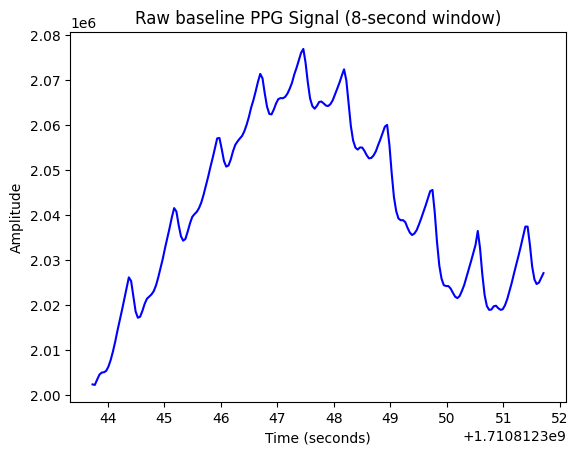

In [27]:
# Load baseline ppg data
baseline_ppg_data = load_data(BASELINE_PPG)

WINDOW_LENGTH = 8
random_number = 42
start_time = baseline_ppg_data['time_s'].iloc[random_number]
end_time = start_time + WINDOW_LENGTH

df_baseline_ppg_window = baseline_ppg_data[
    (baseline_ppg_data['time_s'] >= start_time) &
    (baseline_ppg_data['time_s'] < end_time)
].copy()

baseline_ppg_fs = len(df_baseline_ppg_window) / WINDOW_LENGTH
print("Sampling rate baseline ppg", baseline_ppg_fs)
plt.plot(df_baseline_ppg_window['time_s'], df_baseline_ppg_window['ppg'], 'b-', label='Raw PPG')
plt.title('Raw baseline PPG Signal (8-second window)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()



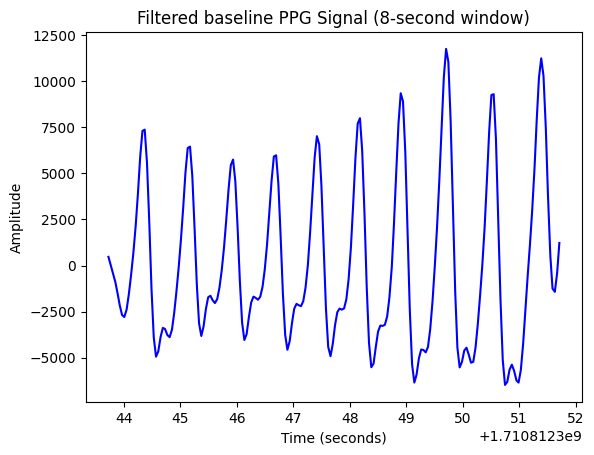

In [28]:
# filter baseline ppg signal
baseline_ppg_values = df_baseline_ppg_window['ppg'].values
lowcut = 0.5
highcut = 4
baseline_ppg_values = bandpass_filter(baseline_ppg_values, baseline_ppg_fs, lowcut, highcut)

plt.plot(df_baseline_ppg_window['time_s'], baseline_ppg_values, 'b-', label='Filtered PPG')
plt.title('Filtered baseline PPG Signal (8-second window)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


Heartpy analysis of ppg for baseline
--------------------------------
Average Heart Rate: 76.9 beats per minute
RMSSD (heart rate variability): 31.9 ms
Number of detected beats: 11




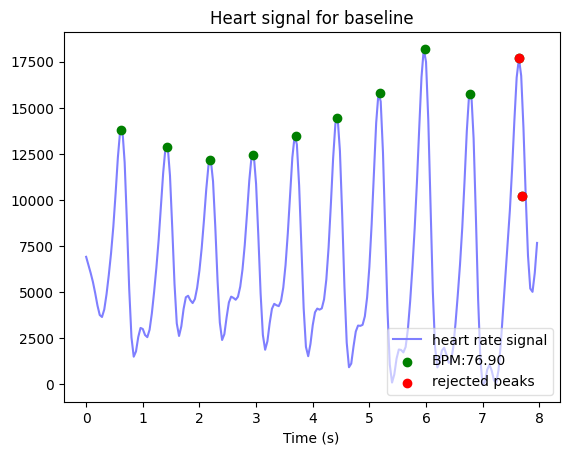

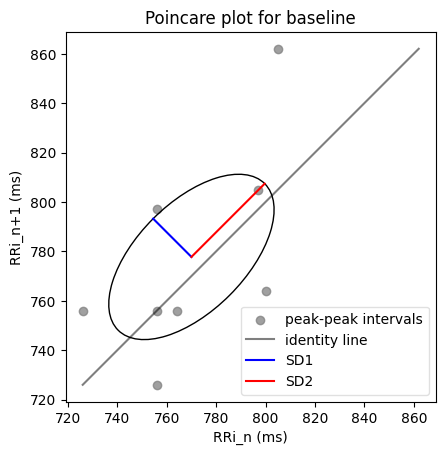

In [29]:
# detect heartbeat
working_data, measures = hp.process(
      baseline_ppg_values,
      sample_rate=baseline_ppg_fs,
      high_precision=True,
      clean_rr=True,
      reject_segmentwise=True
      )

print("Heartpy analysis of ppg for baseline")
print("--------------------------------")
print(f"Average Heart Rate: {measures['bpm']:.1f} beats per minute")
print(f"RMSSD (heart rate variability): {measures['rmssd']:.1f} ms")
print(f"Number of detected beats: {len(working_data['peaklist'])}")
print("\n")

# Plot 1: Signal with peaks
hp.plotter(working_data, measures, show=True,
          title="Heart signal for baseline")

# Plot 2: Poincare plot
hp.plot_poincare(working_data, measures, show=True, title="Poincare plot for baseline")


#Walking ppg

Sampling rate walking ppg 24.875


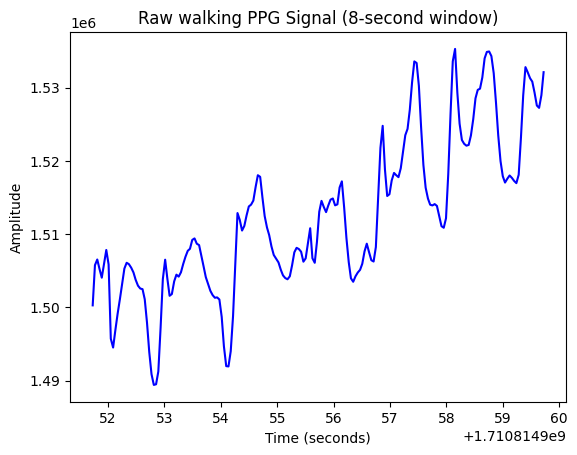

In [30]:
# Load walking ppg data
walking_ppg_data = load_data(WALKING_PPG)

WINDOW_LENGTH = 8
random_number = 42
start_time = walking_ppg_data['time_s'].iloc[random_number]
end_time = start_time + WINDOW_LENGTH

df_walking_ppg_window = walking_ppg_data[
    (walking_ppg_data['time_s'] >= start_time) &
    (walking_ppg_data['time_s'] < end_time)
].copy()

walking_ppg_fs = len(df_walking_ppg_window) / WINDOW_LENGTH
print("Sampling rate walking ppg", walking_ppg_fs)
plt.plot(df_walking_ppg_window['time_s'], df_walking_ppg_window['ppg'], 'b-', label='Raw PPG')
plt.title('Raw walking PPG Signal (8-second window)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

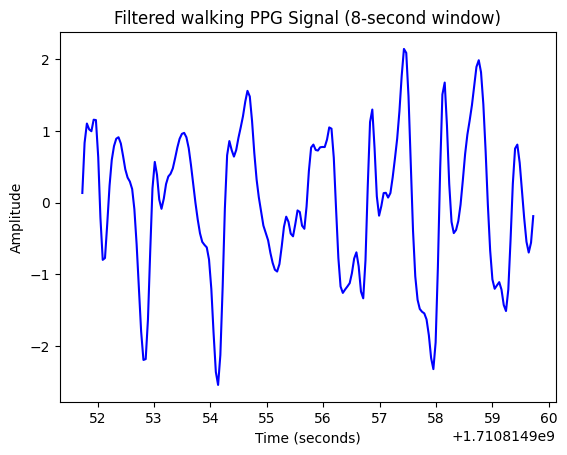

In [31]:

# filter walking ppg signal
walking_ppg_values = df_walking_ppg_window['ppg'].values

#walking_ppg_values = hp.flip_signal(walking_ppg_values)
#walking_ppg_values = hp.filter_signal(walking_ppg_values, cutoff=2.5, sample_rate = baseline_ppg_fs)

def butter_lowpass_filter(data, cutoff=3, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

#fs = walking_ppg_fs  # Sampling frequency (Hz)
#cutoff = 2  # Cutoff frequency (in Hz)
#walking_ppg_values = butter_lowpass_filter(walking_ppg_values, cutoff, fs)

#walking_ppg_values = hp.filter_signal(walking_ppg_values, cutoff=2.5, sample_rate=walking_ppg_fs)

lowcut = 0.4
highcut = 5
walking_ppg_values = bandpass_filter(walking_ppg_values, walking_ppg_fs, lowcut, highcut)

walking_ppg_values = standardize(walking_ppg_values)


plt.plot(df_walking_ppg_window['time_s'], walking_ppg_values, 'b-', label='Filtered PPG')
plt.title('Filtered walking PPG Signal (8-second window)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

Heartpy analysis of ppg for walking
--------------------------------
Average Heart Rate: 95.1 beats per minute
RMSSD (heart rate variability): 81.8 ms
Number of detected beats: 6




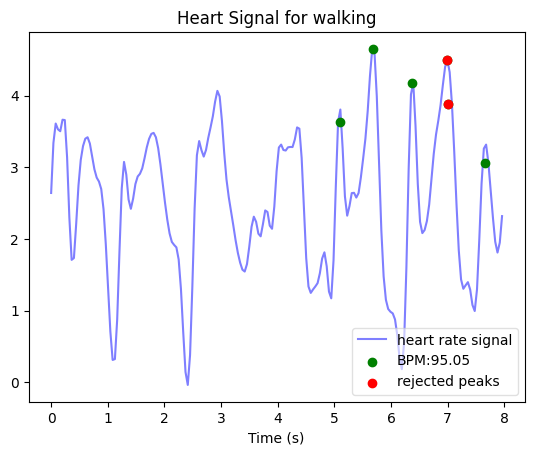

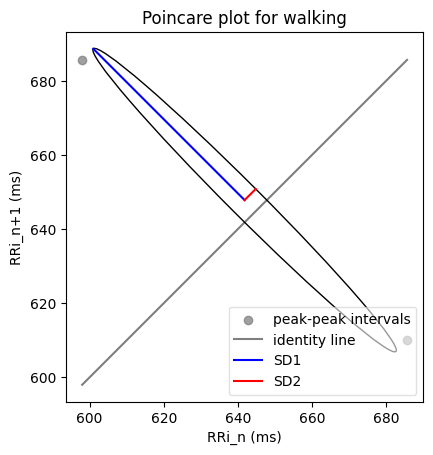

In [32]:
# detect heartbeat
working_data, measures = hp.process(
      walking_ppg_values,
      sample_rate=walking_ppg_fs,
      high_precision=True,
      clean_rr=True,
      reject_segmentwise=True
      )

print("Heartpy analysis of ppg for walking")
print("--------------------------------")
print(f"Average Heart Rate: {measures['bpm']:.1f} beats per minute")
print(f"RMSSD (heart rate variability): {measures['rmssd']:.1f} ms")
print(f"Number of detected beats: {len(working_data['peaklist'])}")
print("\n")

# Plot 1: Signal with peaks
hp.plotter(working_data, measures, show=True,
          title=heart_title)

# Plot 2: Poincare plot
hp.plot_poincare(working_data, measures, show=True, title=poincare_title)

### 2.2 Observations and insights (0.5 point)
After examining the PPG signals, write your observations and insights.
Consider the following aspects:

- What patterns do you notice in the PPG waveform (e.g., systolic peak, diastolic peak, and dicrotic notch)?
- How do the baseline and walking PPG signals differ in terms of shape and characteristics?
- What challenges might you encounter when processing PPG signals, particularly during motion?
- How could these characteristics affect heart rate estimation and other PPG-based measurements?

* Your insights here

The systolic peak, diastolic peak and dicrotic notch is visible on the baseline PPG signal. The systolic peak is the highest peak of the ppg signal. The dicrotic notch is the small notch after systolic and diastolic peak is the secondary peak after the dicrotic notch. These signals are hard to see on the walking PPG signal since it is filled with too much noise. The PPG signal for baseline is therefore much clearer than the walking signal.

The reason for the noise in the walking signal might be from motion, the movement distorts the signal making it harder to detect peaks. Consequentely making it harder to estimate heart rate.

An attempt was made to smooth the walking signal by using butterworth low pass filter and bandpass filter, but this was not enough to clean the signal.